In [1]:
### IMPORTS
from dateroll import ddh
from ratecurve import Curve
from ratecurve.ratecurve import disc_factor
import matplotlib.pyplot as plt

In [2]:
### INSTANTIATE CURVE
curve_data =  {
    "0m":.053,    
    "1m":.0548,
     "2m":.0551,
     "3m":.0545,
     "4m":.0544,
     "6m":.0538,
     "1y":.0517,
     "2y":.0493,
     "3y":.0477,
     "5y":.0461,
     "7y":.0460,
     "10y":.0456,
     "20y":.0477,
     "30y":.0465}

curve = Curve(curve_data)

In [55]:
### GENERATE DATA

# Settings
anchor_date = ddh('t')
tenors_to_interpolate = ['1d','1w','2w','1m','2m','3m','4m','6m','9m','1y','18m','2y','3y','4y','5y','7y','10y','15y','20y','25y','30y']
dates_to_interpolate = [anchor_date +ddh(x) for x in tenors_to_interpolate]
forward_tenor = "3m"

# Result variable instantiation
spot_dates = []
spot_tenors = []
spot_x = []
spot_rates = []
spot_dfs = []

forward_dates = []
forward_tenors = []
forward_x = []
forward_rates = []
forward_dfs = []

print('-------------PAR DATA----------------')
get_t = lambda b: (ddh(f't+{b}')-ddh('t')).yf("ALL","ACT/365")
par_tenors =  list(curve_data.keys())
par_dates = [anchor_date+ddh(x) for x in par_tenors]
par_rates = list(curve_data.values())
par_dfs = [disc_factor(par_rates[i],get_t(par_tenors[i]),method="EXP") for i in range(len(par_tenors))]
par_x = [ddh(x).just_days for x in curve_data]

for i in range(len(par_dates)):
    print(f'Tenor:{par_tenors[i]}, Par:{par_rates[i]}')
print('\n\n')
print('------------SPOT INTERPOLATION START-------------')
for i in range(len(dates_to_interpolate)):
    spot_rate = curve.spot(dates_to_interpolate[i])
    spot_df = curve.spot(dates_to_interpolate[i], returns = 'df')
    #x values
    spot_dates.append(dates_to_interpolate[i].to_string())
    spot_tenors.append((dates_to_interpolate[i]-ddh('t')).to_string())
    spot_x.append((dates_to_interpolate[i]-ddh('t')).just_days)
    #y values
    spot_rates.append(spot_rate)
    spot_dfs.append(spot_df)
    print(f'Tenor:{tenors_to_interpolate[i]}, Spot:{spot_rate}')
print('------------SPOT INTERPOLATION FINISH-----------')
print('\n\n')
print(f'-----------{forward_tenor} FORWARD INTERPOLATION START --------------')
for i in range(len(dates_to_interpolate)-1):
    fwd_date = ddh(dates_to_interpolate[i]) + ddh(forward_tenor)
    fwd_rate = curve.fwd(dates_to_interpolate[i],fwd_date)
    fwd_df = curve.fwd(dates_to_interpolate[i],fwd_date,returns = 'df')

    #y values
    forward_rates.append(fwd_rate)
    forward_dfs.append(fwd_df)
    #x vlaues
    forward_x.append((dates_to_interpolate[i]-ddh('t')).just_days) 
    forward_dates.append(dates_to_interpolate[i].to_string())
    forward_tenors.append((dates_to_interpolate[i]-ddh('t')).to_string())
    print(f'Tenors:({tenors_to_interpolate[i]},{tenors_to_interpolate[i]}+{forward_tenor}), Rate:{fwd_rate}')
print(f'-----------{forward_tenor} FORWARD INTERPOLATION FINISH--------------')

-------------PAR DATA----------------
Tenor:0m, Par:0.053
Tenor:1m, Par:0.0548
Tenor:2m, Par:0.0551
Tenor:3m, Par:0.0545
Tenor:4m, Par:0.0544
Tenor:6m, Par:0.0538
Tenor:1y, Par:0.0517
Tenor:2y, Par:0.0493
Tenor:3y, Par:0.0477
Tenor:5y, Par:0.0461
Tenor:7y, Par:0.046
Tenor:10y, Par:0.0456
Tenor:20y, Par:0.0477
Tenor:30y, Par:0.0465



------------SPOT INTERPOLATION START-------------
Tenor:1d, Spot:0.05479999999996131
Tenor:1w, Spot:0.054800000000000626
Tenor:2w, Spot:0.05480000000000018
Tenor:1m, Spot:0.05480000000000051
Tenor:2m, Spot:0.05509999999999958
Tenor:3m, Spot:0.05450000000000008
Tenor:4m, Spot:0.0544000000000001
Tenor:6m, Spot:0.05379999999999982
Tenor:9m, Spot:0.05239104895104894
Tenor:1y, Spot:0.05170000000000011
Tenor:18m, Spot:0.05009708029197092
Tenor:2y, Spot:0.04929999999999996
Tenor:3y, Spot:0.04769999999999999
Tenor:4y, Spot:0.04669876909075076
Tenor:5y, Spot:0.04610000000000001
Tenor:7y, Spot:0.04599999999999997
Tenor:10y, Spot:0.04559999999999997
Tenor:15y, Spot:0

/home/disent/pyenvtest312/lib/python3.12/site-packages/dateroll/duration/duration.py:399: UserWarning: [dateroll] just_days using approx: ≈30.437500d 
  warnings.warn(message)
/home/disent/pyenvtest312/lib/python3.12/site-packages/dateroll/duration/duration.py:399: UserWarning: [dateroll] just_days using approx: ≈60.875000d 
  warnings.warn(message)
/home/disent/pyenvtest312/lib/python3.12/site-packages/dateroll/duration/duration.py:399: UserWarning: [dateroll] just_days using approx: ≈91.312500d 
  warnings.warn(message)
/home/disent/pyenvtest312/lib/python3.12/site-packages/dateroll/duration/duration.py:399: UserWarning: [dateroll] just_days using approx: ≈121.750000d 
  warnings.warn(message)
/home/disent/pyenvtest312/lib/python3.12/site-packages/dateroll/duration/duration.py:399: UserWarning: [dateroll] just_days using approx: ≈182.625000d 
  warnings.warn(message)
/home/disent/pyenvtest312/lib/python3.12/site-packages/dateroll/duration/duration.py:399: UserWarning: [dateroll] just

In [60]:
# PLOTTING FUNCTION

def plot_curve(spacing = 'actual', y_axis = 'rate', x_axis = 'tenor', to_plot = ['par','spot','forward']):
    # Globals
    global spot_dates
    global spot_tenors
    global spot_x
    global spot_rates
    global spot_dfs
    
    global forward_dates
    global forward_tenors
    global forward_x
    global forward_rates
    global forward_dfs
    
    global par_tenors
    global par_dates
    global par_rates
    global par_dfs
    global par_x
    
    # y_vals
    par_y = par_rates if y_axis == 'rate' else par_dfs
    spot_y = spot_rates if y_axis == 'rate' else spot_dfs
    forward_y = forward_rates if y_axis == 'rate' else forward_dfs
    
    # x_vals
    #even spacing calculation
    # this scales x_vals so that all days are evenly spaced
    # 1. Find all unique x_vals (integer days since root date of curve class)
    # 2. Sort them and map unique values to their sorted index
    unique_xs = sorted(list(set((par_x + list(spot_x)) + list(forward_x))))
    x_map = {unique_xs[i]:i for i in range(len(unique_xs))}
    par_even_x = [x_map[val] for val in par_x]
    spot_even_x = [x_map[val] for val in spot_x]
    forward_even_x = [x_map[val] for val in forward_x]
    
    
    # Plot generation    
    fig,ax = plt.subplots()
    
    if 'par' in to_plot:
        spaced_par_x = par_x if spacing == 'actual' else par_even_x
        ax.plot(spaced_par_x, par_y, label="Par")
    if 'forward' in to_plot:
        spaced_forward_x = forward_x if spacing == 'actual' else forward_even_x
        ax.plot(spaced_forward_x, forward_y, label="3m Forward")
    if 'spot' in to_plot:
        spaced_spot_x = spot_x if spacing == 'actual' else spot_even_x
        ax.plot(spaced_spot_x, spot_y, label="Spot")
    
    labels = spot_tenors if x_axis == 'tenor' else spot_dates
    ###for actual spacing
    if spacing == 'actual':
        labels_subset = [labels[i] for i in range(len(labels)) if i in [0,9,11,12,13,14,15,16,17,18,19,20,21]]
        ticks_subset = [spot_x[i] for i in range(len(labels)) if i in [0,9,11,12,13,14,15,16,17,18,19,20,21] ]
        rotation = 60 if x_axis == 'date' else 90
        plt.xticks(ticks = ticks_subset,labels=labels_subset,rotation=rotation)
    else:
        labels_subset = [labels[i] for i in range(len(labels))]
        ticks_subset = [spot_x[i] for i in range(len(labels))]
        plt.xticks(ticks = ticks_subset,labels=labels_subset,rotation=90)
    
    x_label = f'{x_axis.capitalize()}'
    y_label = f'{y_axis.capitalize()}'
    title = f'Curve'
    print(spaced_spot_x)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()


[1, 2, 3, 4, 7, 8, 11, 13, 14, 15, 17, 18, 20, 22, 23, 25, 27, 29, 30, 31, 32]


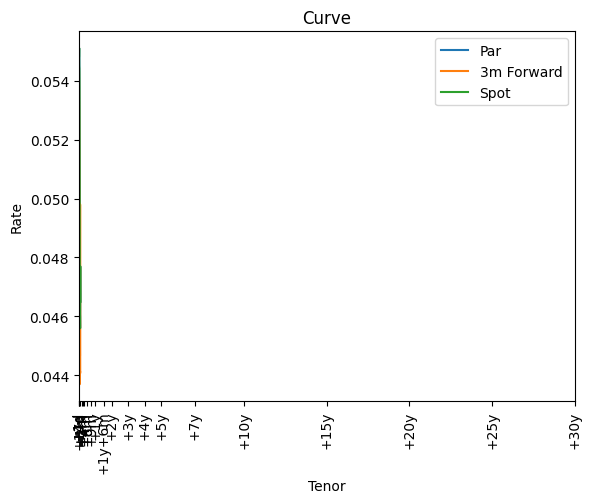

In [61]:
# PLOT GENERATION
# Settings
settings = {
'spacing':'even', #'actual' or 'equal'
'y_axis':'rate', # 'rate' or 'df'
'x_axis':'tenor', # 'date' or 'tenor'
'to_plot':['par', 'spot', 'forward'] # choices are 'par', 'spot' and 'forward'
}

plot_curve(**settings)